In [1]:
import sys
sys.path.append('../training_performance')

import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 

# settingsb
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

[2024-03-19 23:48:51,895][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2024-03-19 23:48:53,176][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [51]:
animals = [
    "R010",
    "R011",
    "R012",
    "R015",
    "R023",
    "R024",
    "R025",
    "R027",
    "R029",
    "R032",
    "R034",
    "C215",
    "C220",
    "C222",
]

successful = ["C222", "R025", "R032", "R034"]
budding = ["R027", "R010", "R011", "R012", "R024"]
stuck = ["C215", "C220", "R015", "R029"]

f_path = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/meetings/2024_03_20_Meeting_Plots.csv"

date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=12)
df = create_trials_df_from_dj(animals, date_min, date_max)  # 2024-03-07 and 2024-03-20

df.to_csv(
    f_path,
    index=False,
)
# df = pd.read_csv(f_path)

fetched 14 sessions for R010 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R011 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R012 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R015 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R023 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R024 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R025 between 2024-03-08 and 2024-03-20
fetched 13 sessions for R027 between 2024-03-08 and 2024-03-20
fetched 11 sessions for R029 between 2024-03-08 and 2024-03-20
fetched 12 sessions for R032 between 2024-03-08 and 2024-03-19
fetched 12 sessions for R034 between 2024-03-08 and 2024-03-19
fetched 12 sessions for C215 between 2024-03-08 and 2024-03-19
fetched 13 sessions for C220 between 2024-03-08 and 2024-03-20
fetched 12 sessions for C222 between 2024-03-08 and 2024-03-19


In [52]:
def check_adaptive(group):
    group["adaptive"] = any(group.give_del_growth_type == "adaptive")
    return group


df = df.groupby(["animal_id", "date"]).apply(check_adaptive).reset_index(drop=True)

# df = df.query("adaptive == 1").copy()

## Across Sessions 

In [50]:
def plot_adaptive_threshold_summary_days(df, animal_id):
    fig, ax = plt.subplots(3, 1, figsize=(12, 4 * 3), sharex=True)

    plot_df = df.query("animal_id == @animal_id").copy()

    plot_stim_performance_by_pro_anti(
        plot_df, aesthetics=False, ax=ax[0], title="Pro & Anti Perf"
    )
    plot_give_use_rate_days(
        plot_df, ax[1], aesthetics=False, title="Give Delivered Rate"
    )
    plot_give_delay_dur_days_line(
        plot_df, aesthetics=False, ax=ax[2], title="Avg. Delay Pre-Give"
    )

    # add info for adaptive threshold
    sns.lineplot(
        data=plot_df,
        x="date",
        y="give_del_adagrow_alpha_minus",
        marker="x",
        color="k",
        ax=ax[1],
        label="Alpha Minus",
    )
    ax[1].set_title(
        f"Current $\\alpha_-= {plot_df.give_del_adagrow_alpha_minus.iloc[-1]}$"
    )

    _ = plt.xticks(rotation=45)
    ax[2].set(ylim=(0, None))

    plt.suptitle(f"{animal_id} Adaptive Growth Summary")

    return None

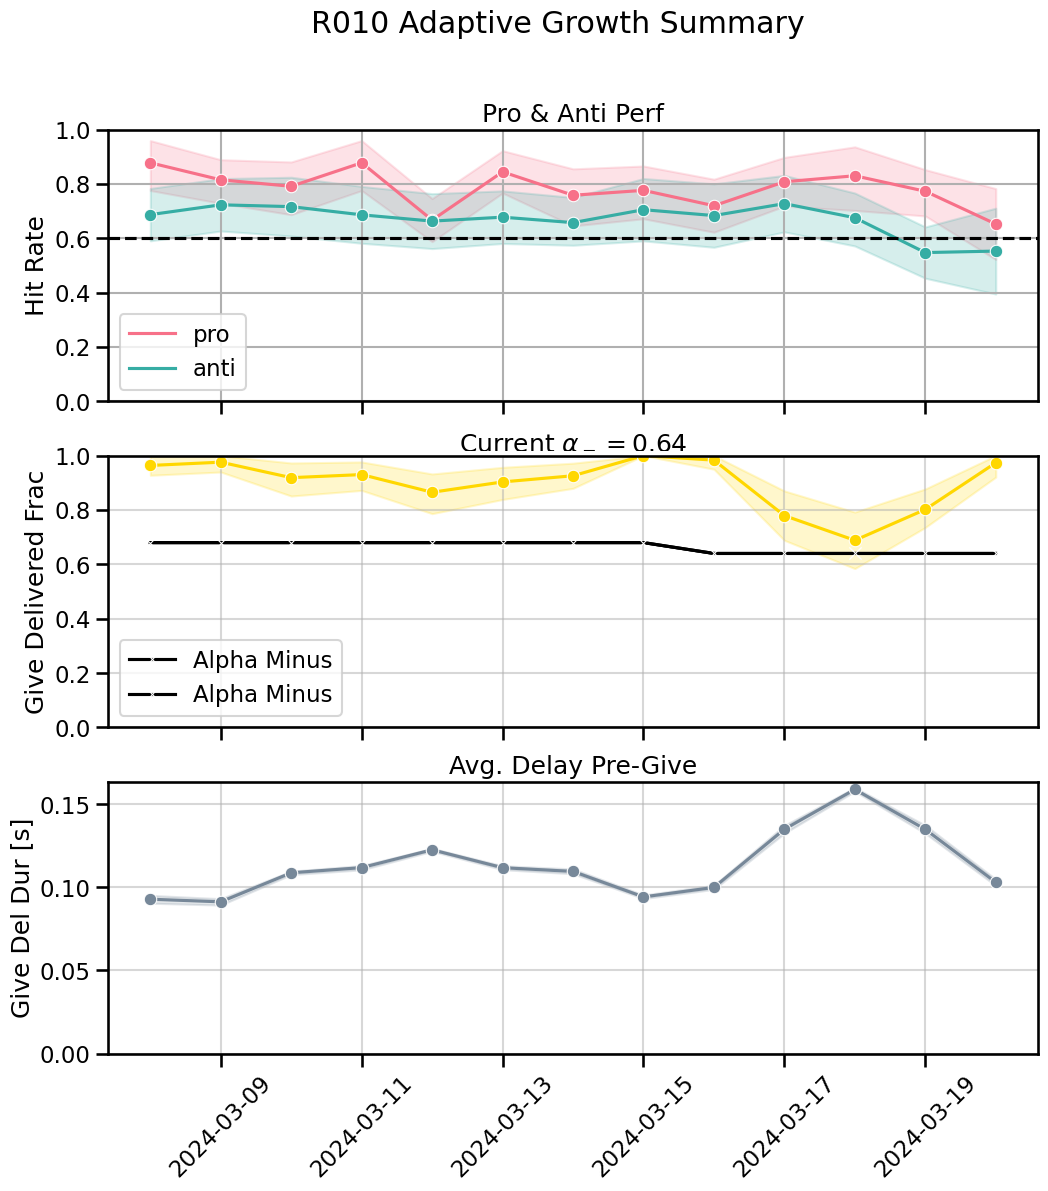

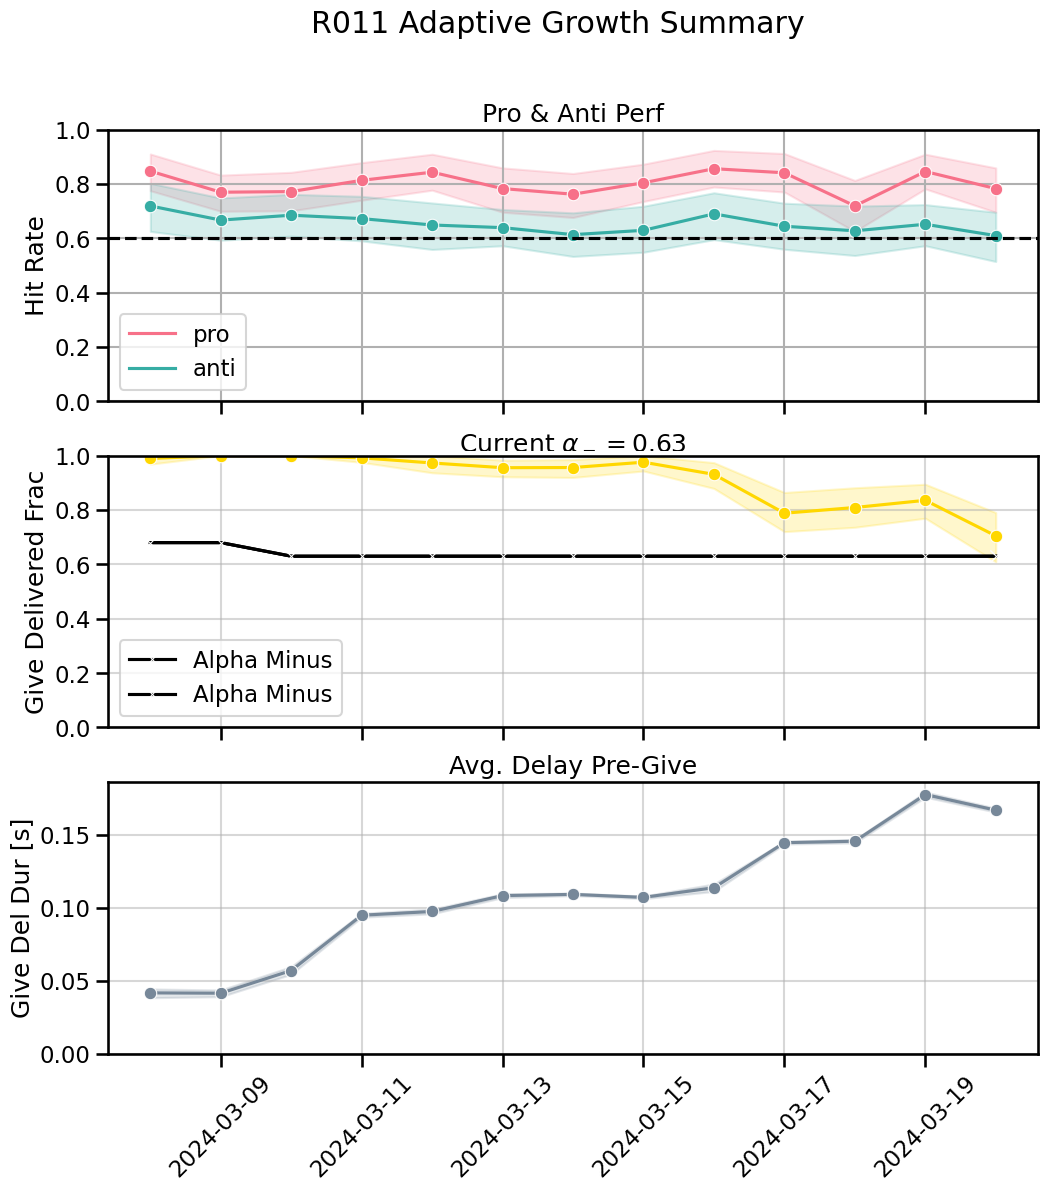

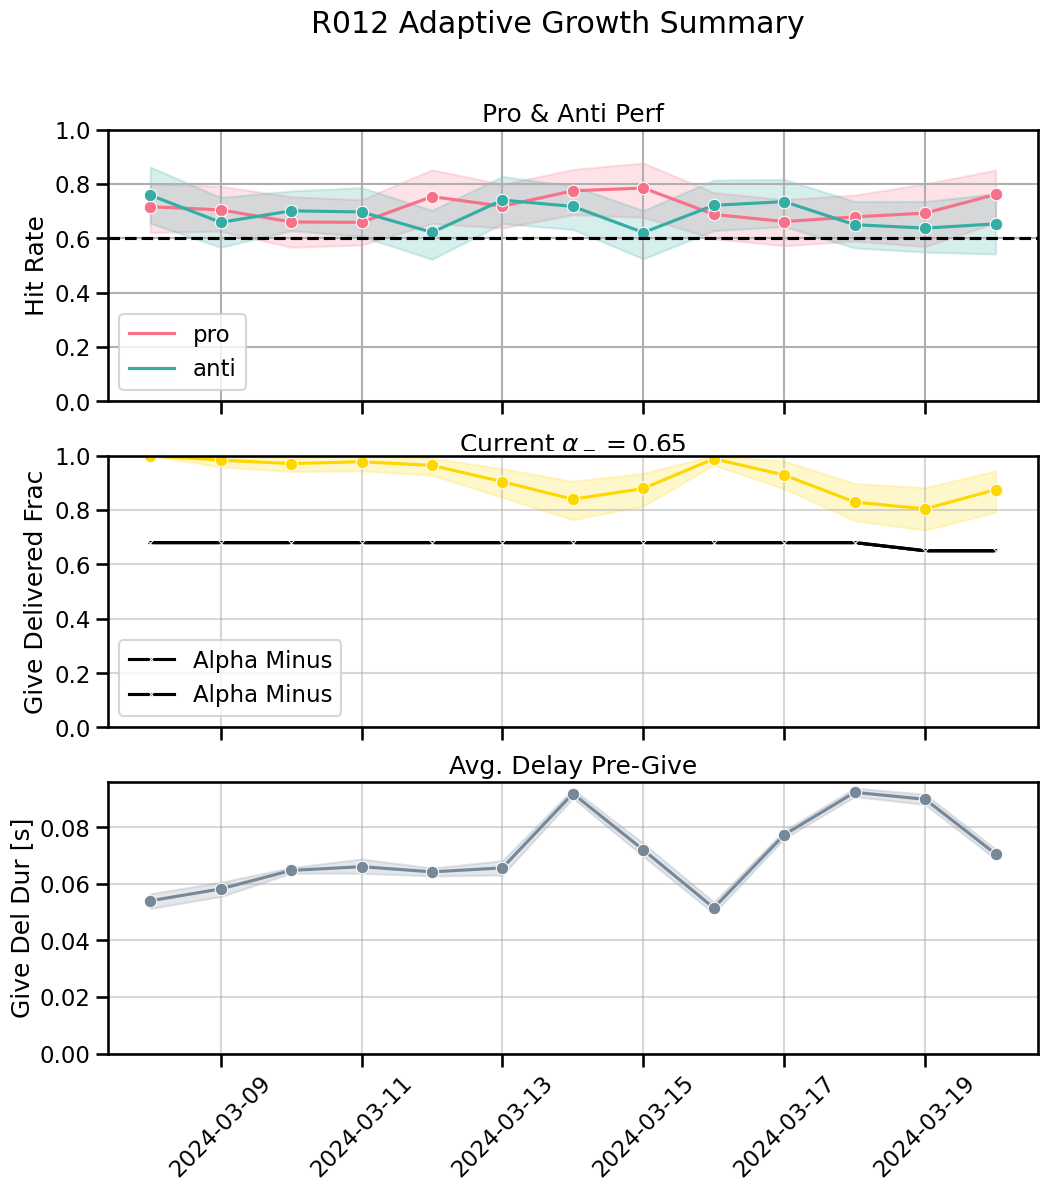

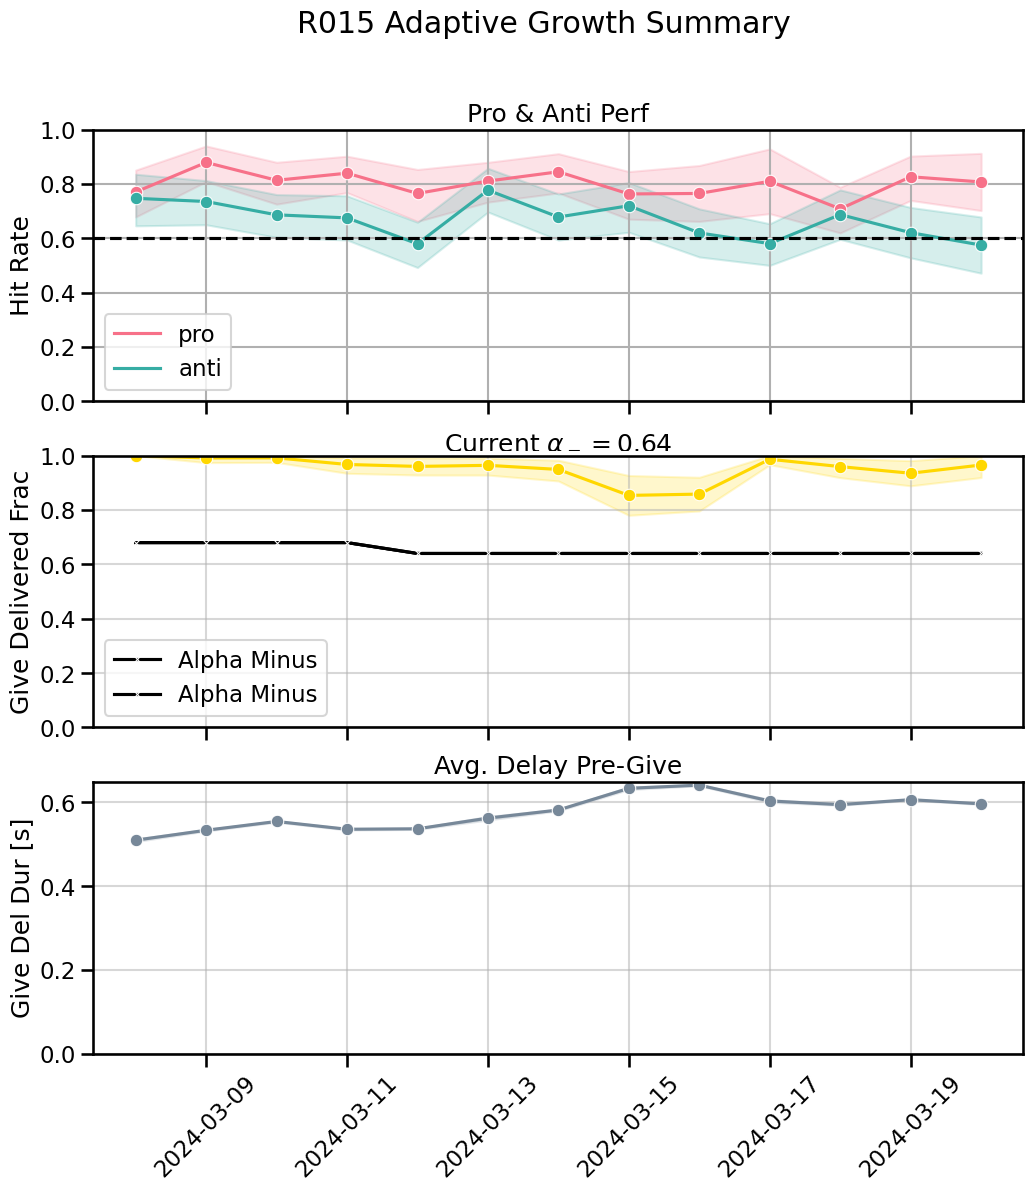

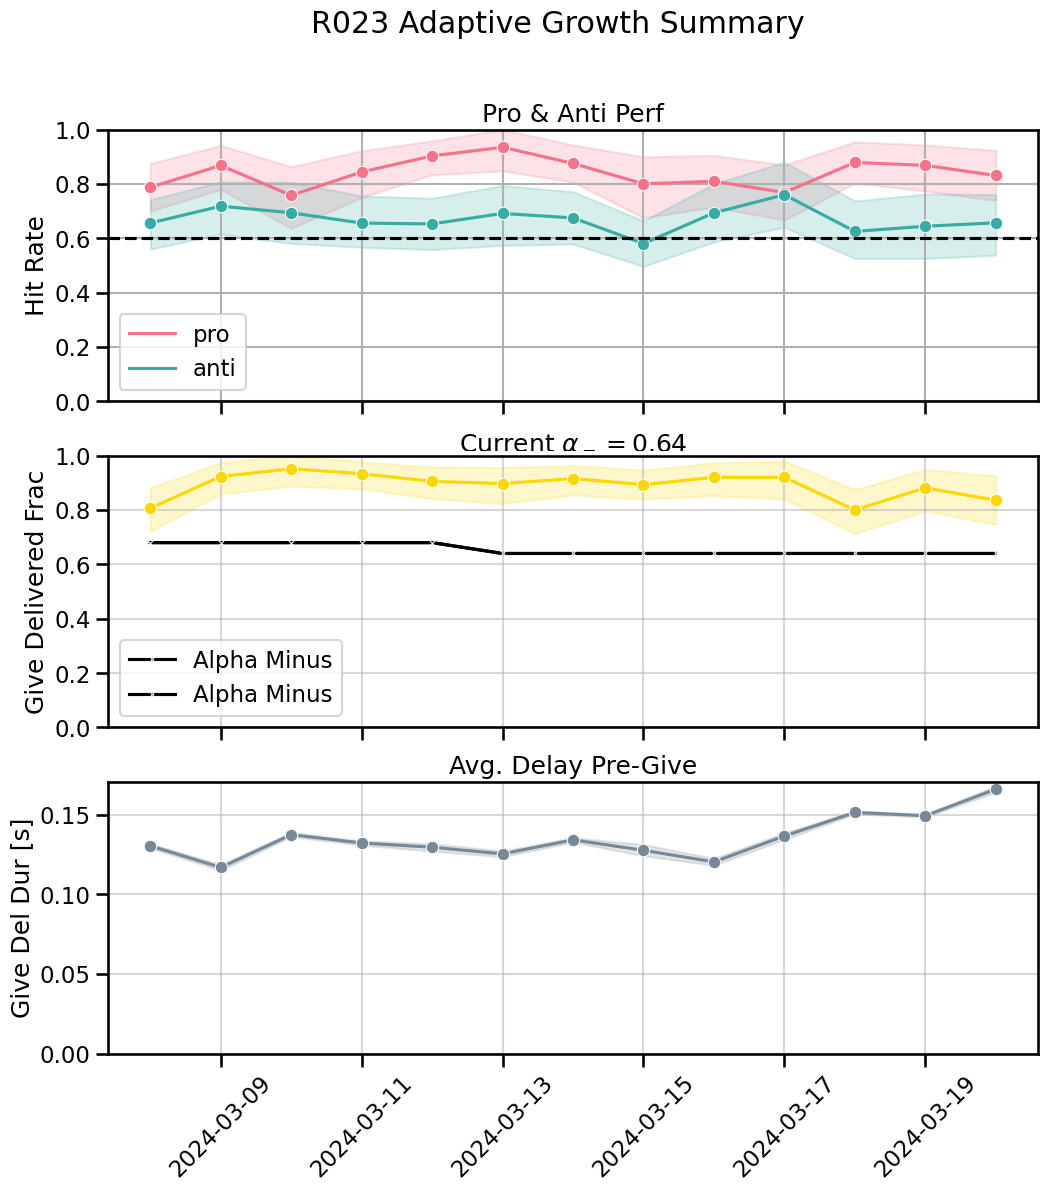

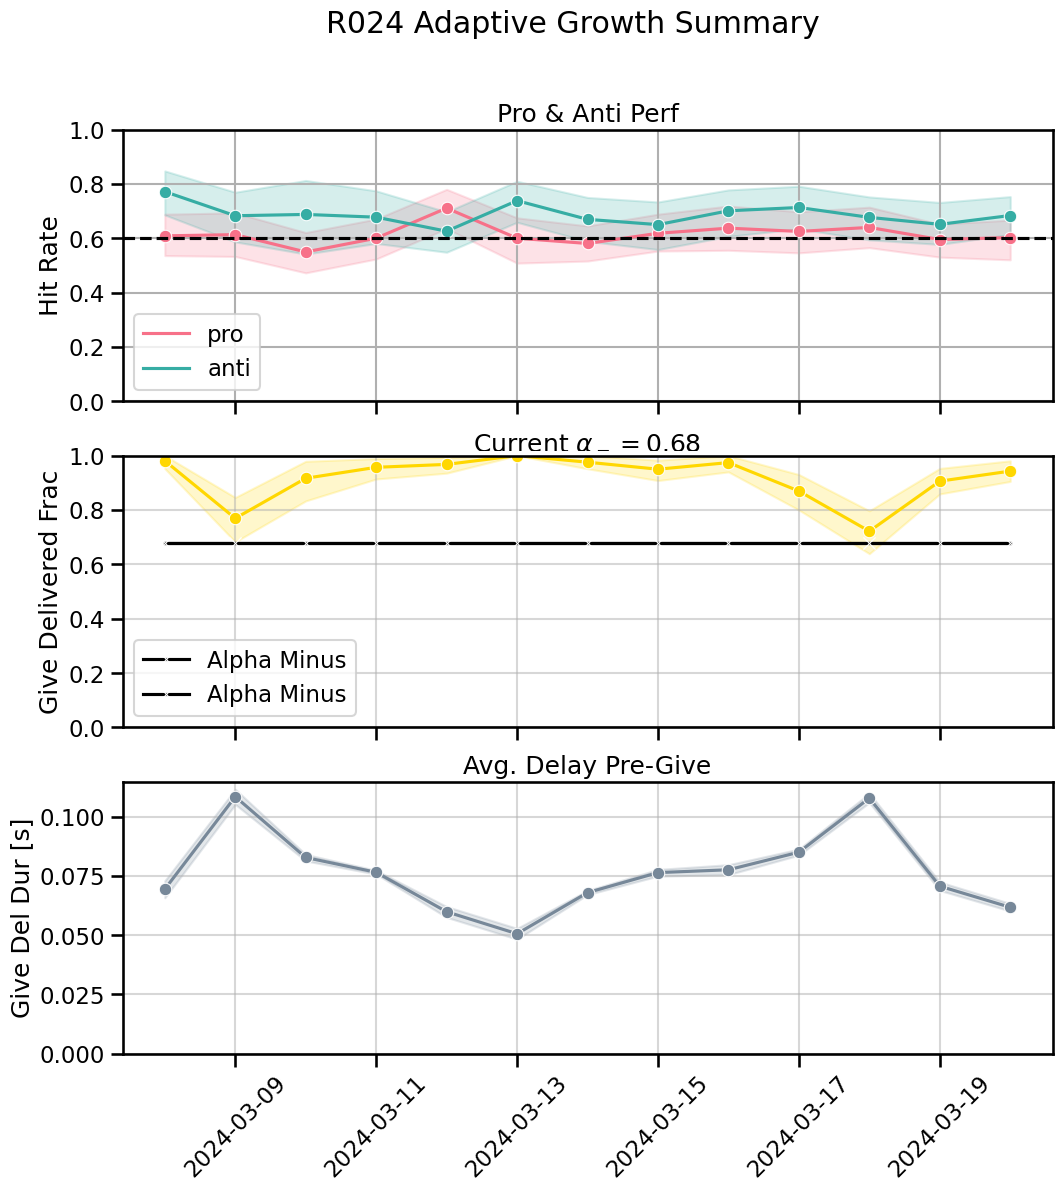

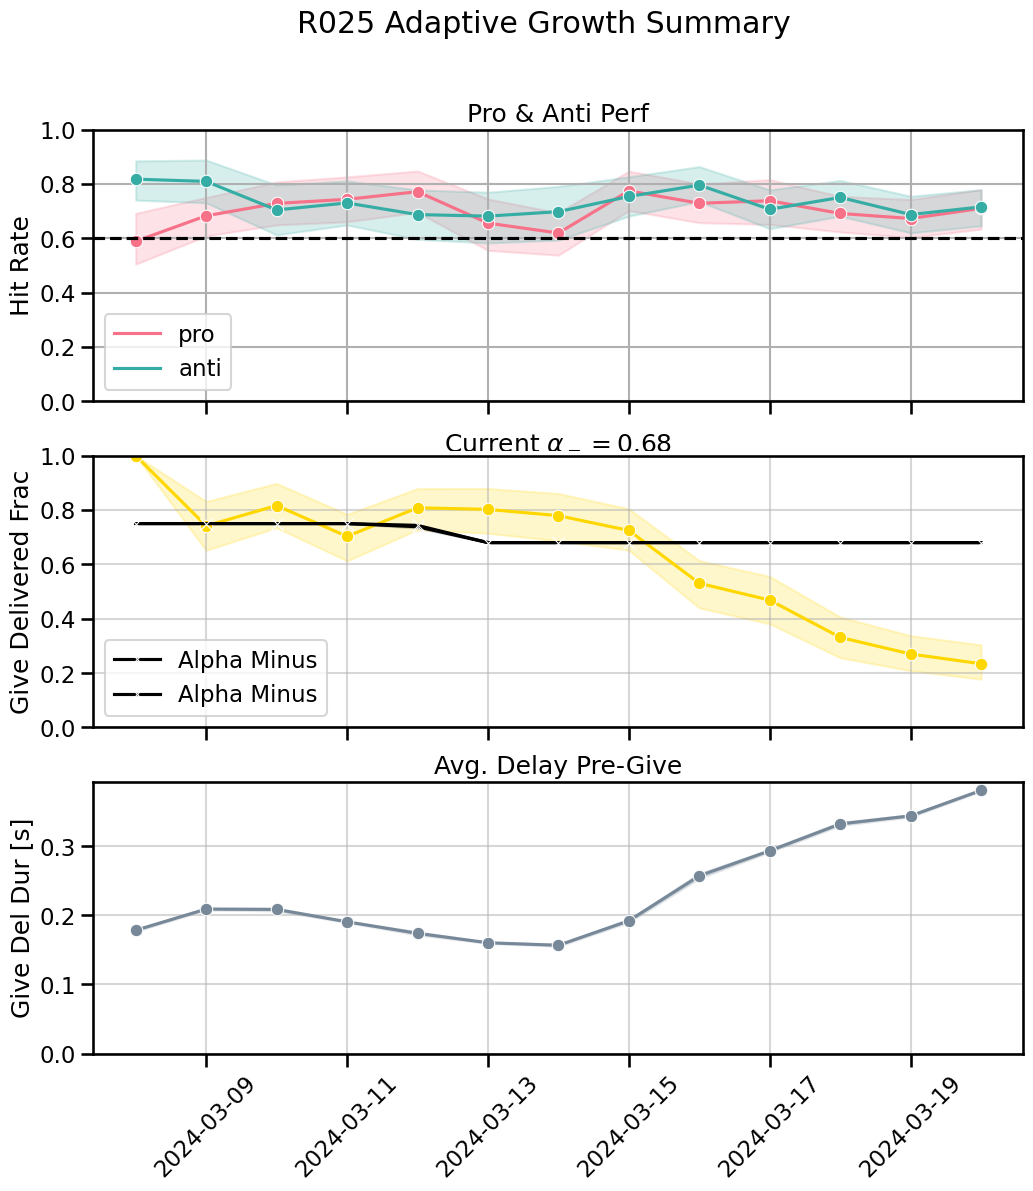

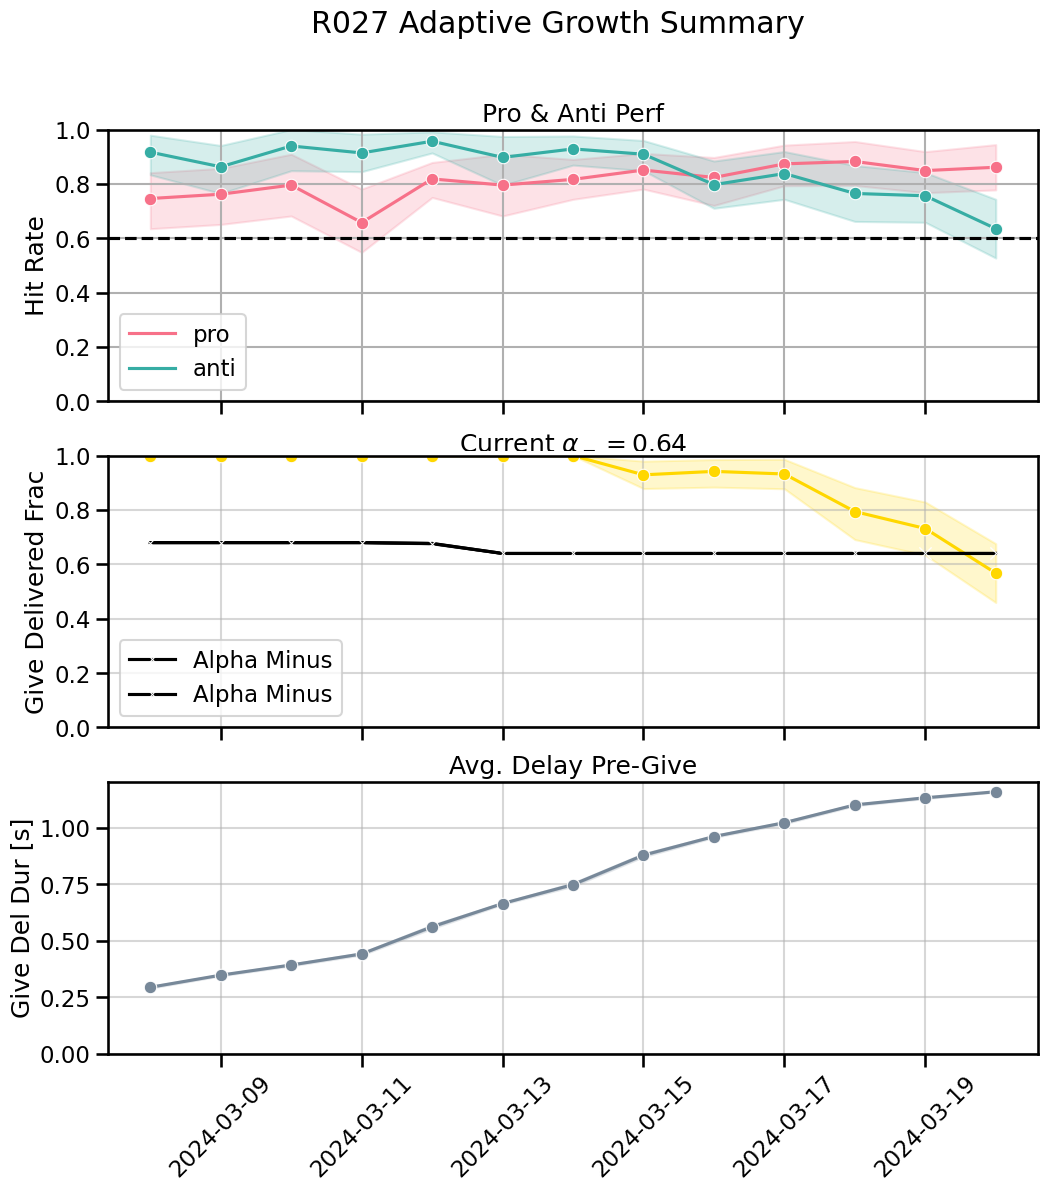

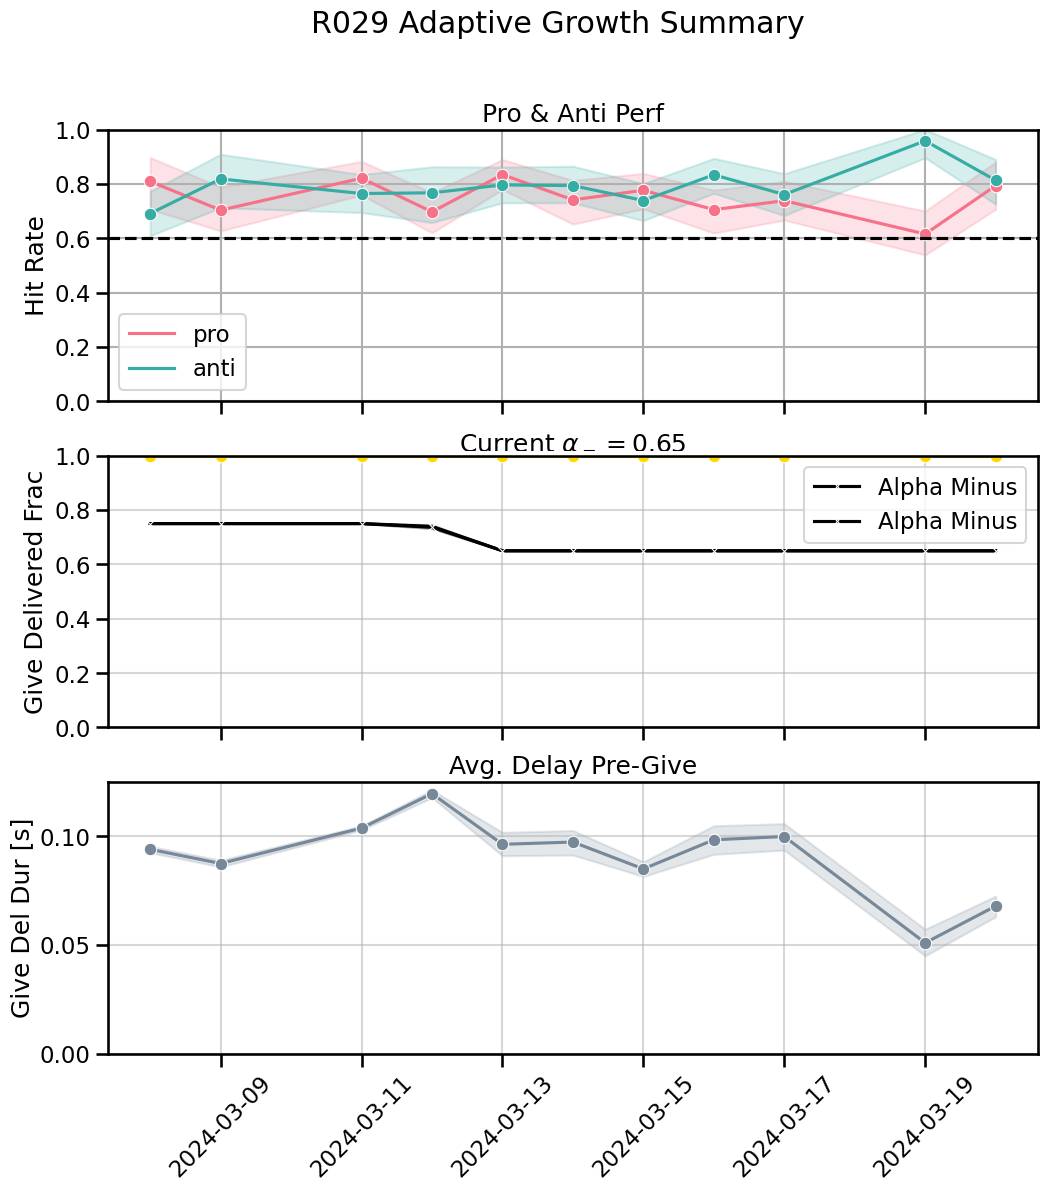

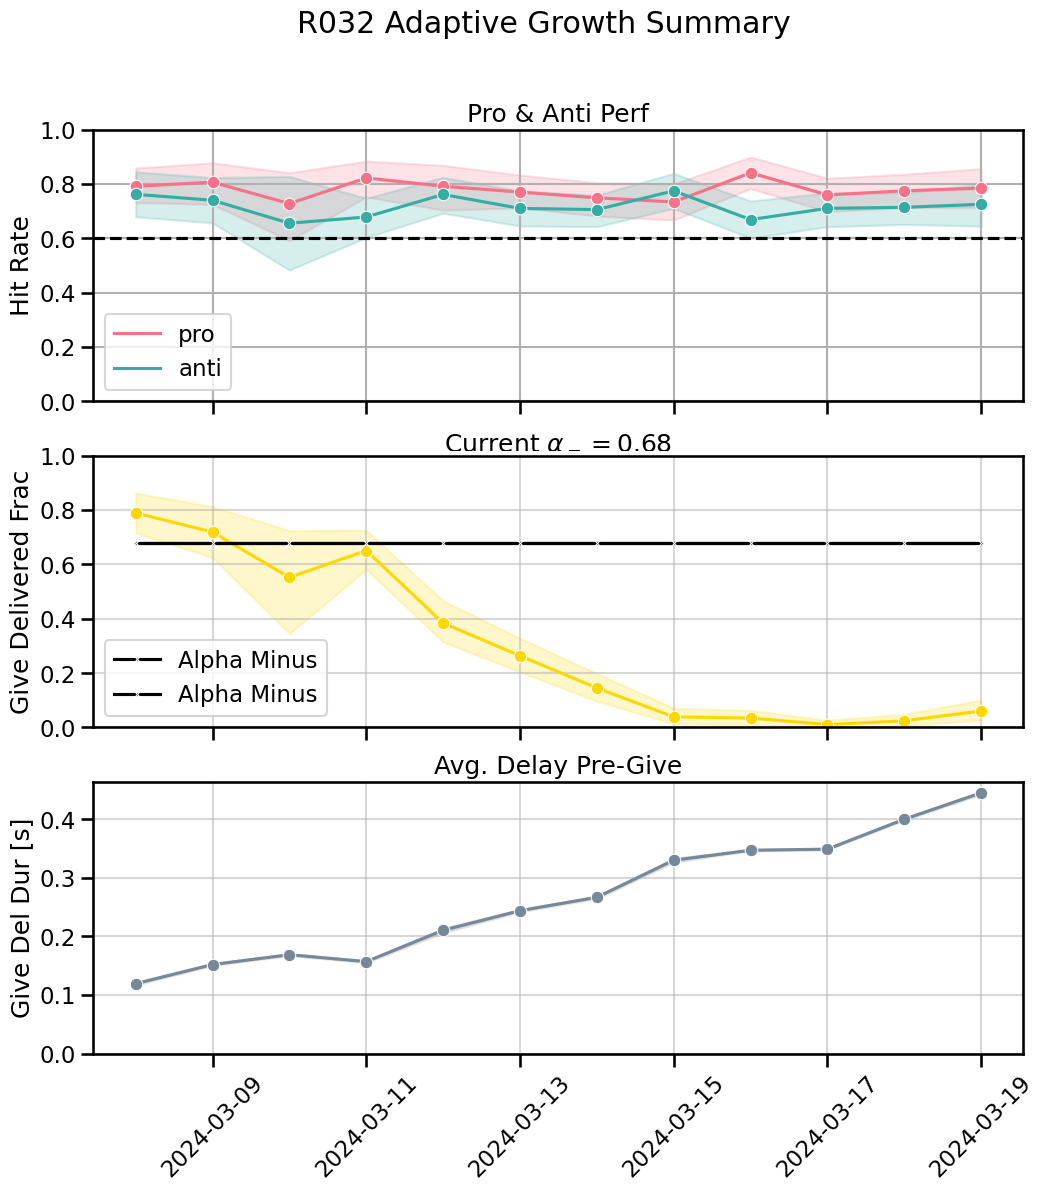

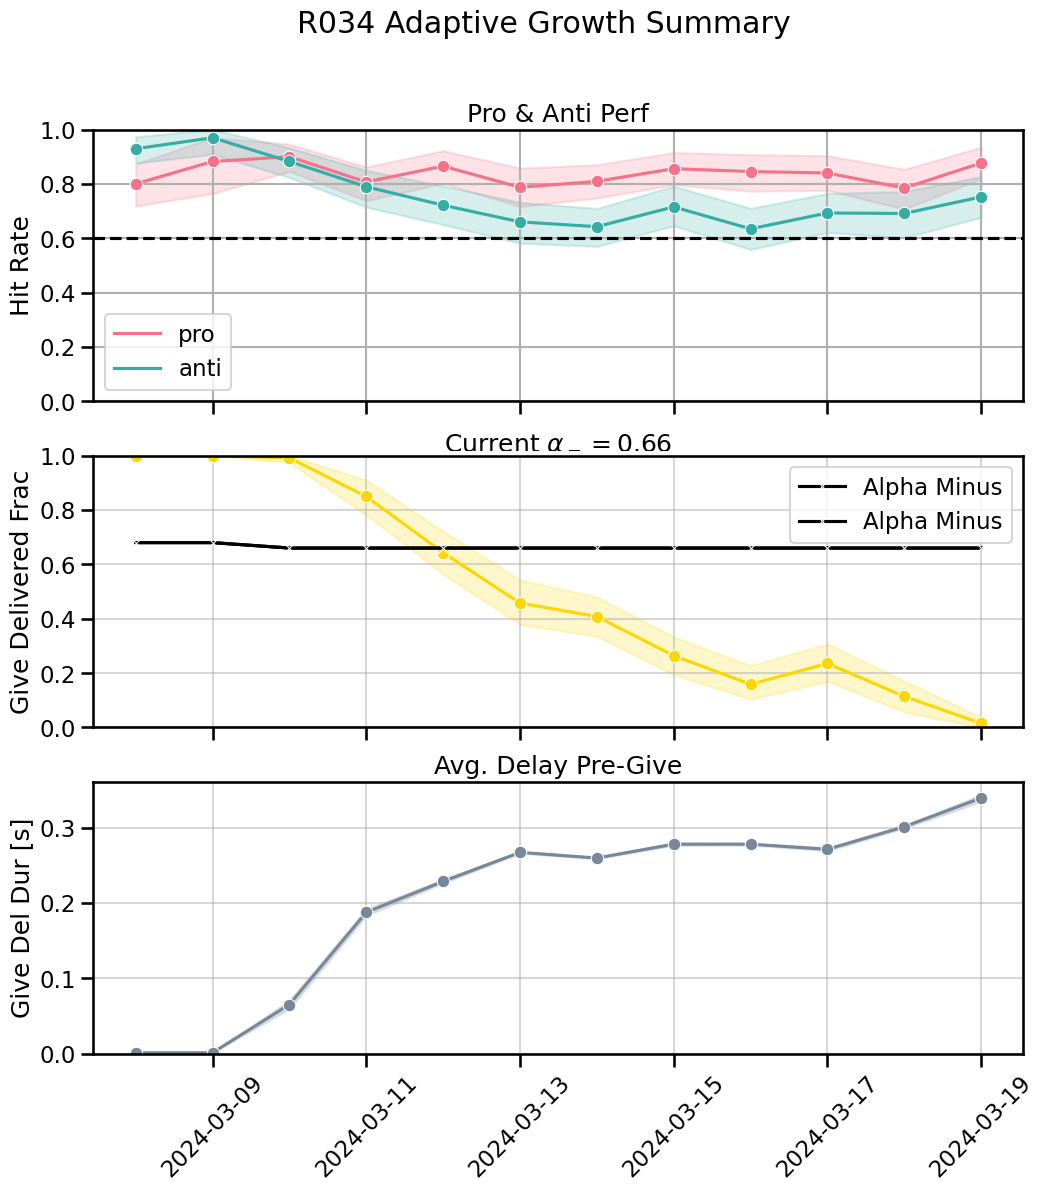

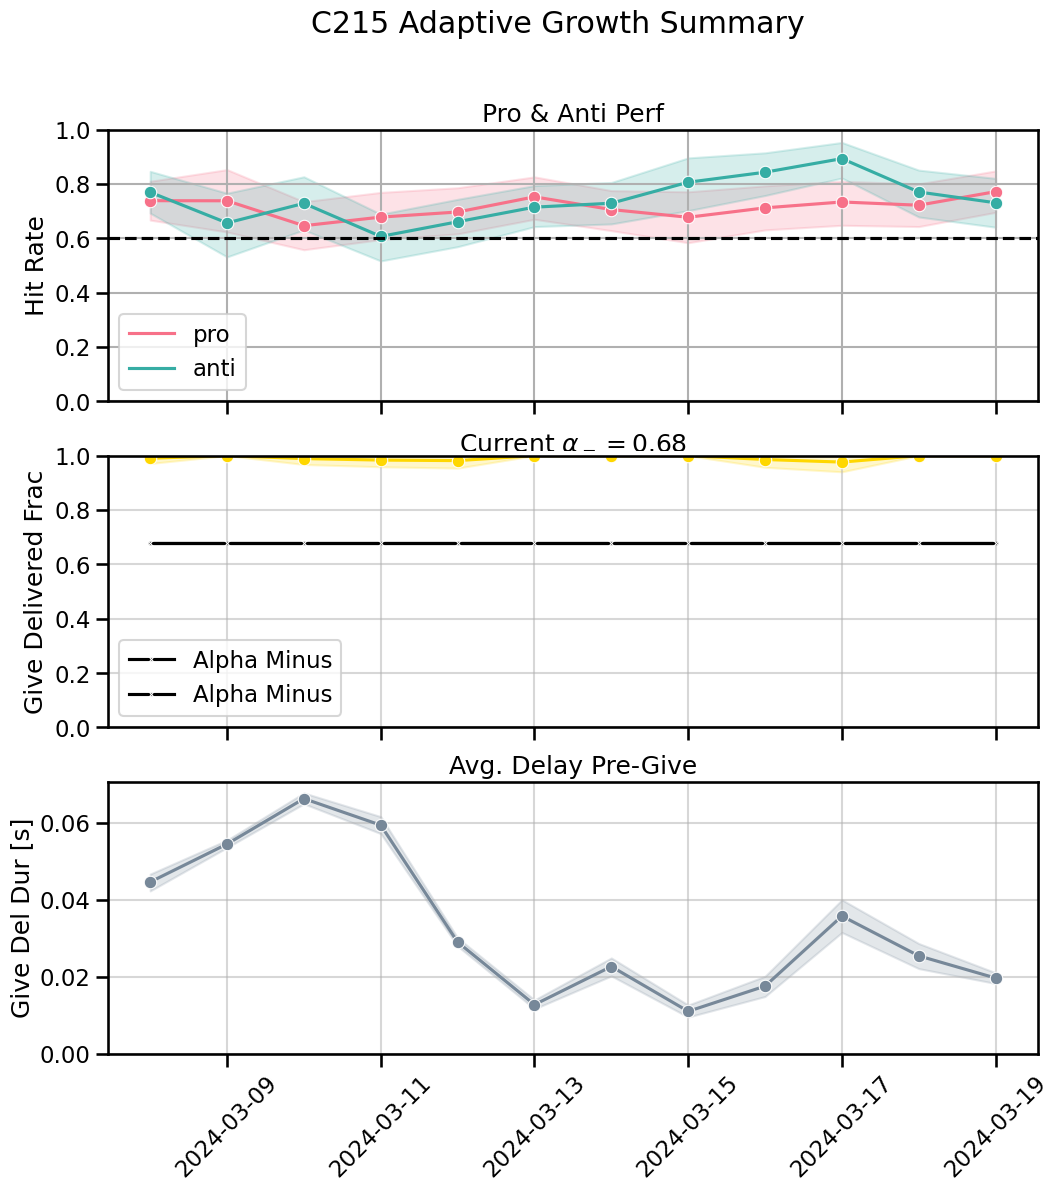

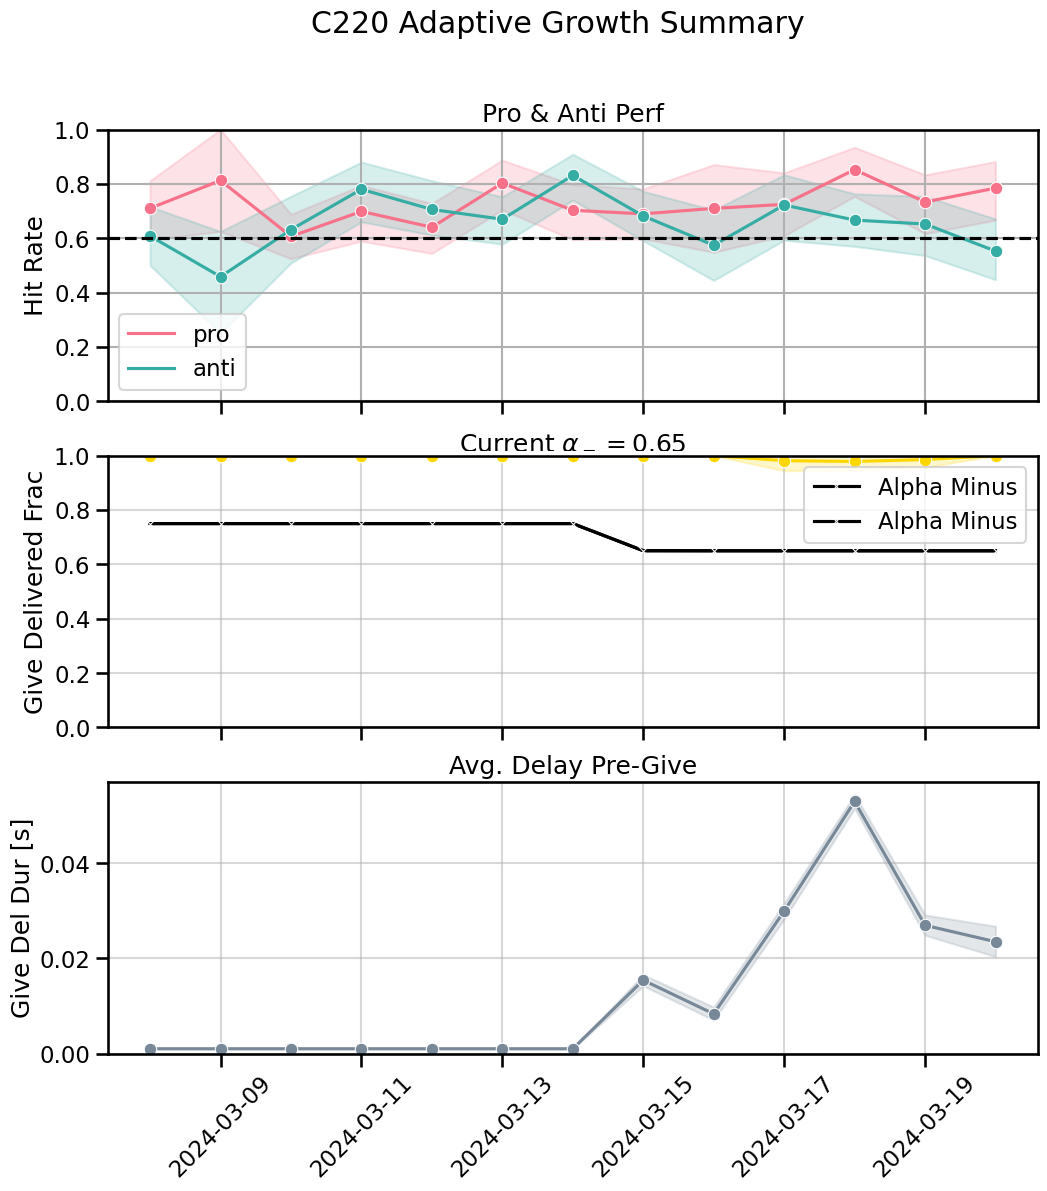

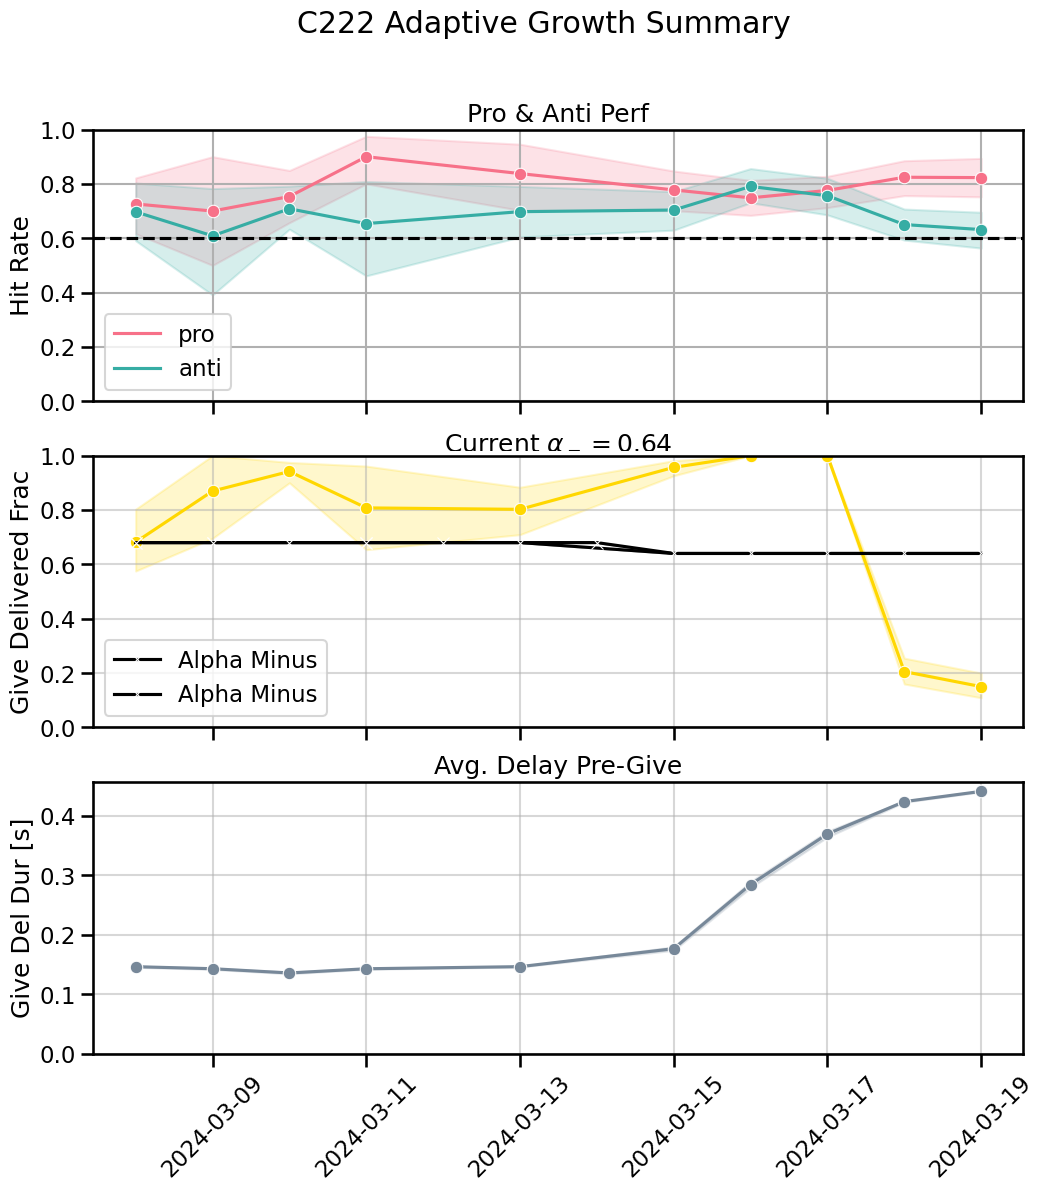

In [53]:
for animal_id in animals:
    plot_adaptive_threshold_summary_days(df, animal_id)

## Within Sessions

In [47]:
def plot_adaptive_within_session_over_days(
    df, animal_id, save_out=False, save_path=None
):

    # check if save path exists, and make the folder if not using the
    if save_out:
        save_Path = Path(save_path)
        if not save_Path.exists():
            save_Path.mkdir(parents=True)

    plot_df = df.query("animal_id == @animal_id").copy()

    for idx, (date, sub_df) in enumerate(plot_df.groupby("date")):
        if len(sub_df.pro_anti_block_type.unique()) == 1:
            continue

        fig = plt.figure(constrained_layout=True, figsize=(15, 8))
        layout = """
            AAAB
            CCCD
        """
        ax_dict = fig.subplot_mosaic(layout)

        plot_rolling_hit_rate_by_pro_anti(sub_df, ax_dict["A"])
        plot_anti_hit_rate_by_give_use(sub_df, ax=ax_dict["B"])
        plot_anti_give_del_metrics(
            sub_df,
            ax_dict["C"],
            title=f"alpha - = {sub_df.give_del_adagrow_alpha_minus.min()} ",
        )
        plot_anti_hit_counts_by_give_use(sub_df, ax=ax_dict["D"], legend=False)

        fig.suptitle(f"{animal_id} on {date}")

        if save_out:
            plt.savefig(save_path + f"{animal_id}_{date}_adaptive_give_dur_plots.png")
            plt.close(fig)

In [46]:
for animal_id in animals:
    plot_adaptive_within_session_over_days(
        df,
        animal_id,
        save_out=True,
        save_path="/Users/jessbreda/Desktop/github/jbreda_animal_training/figures/meetings/2024_03_20/",
    )